In [66]:
import pandas as pd
import numpy as np
import seaborn as sns
import japanize_matplotlib
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from pycaret.classification import setup, compare_models, tune_model, finalize_model, predict_model, plot_model, calibrate_model
plt.rcParams["font.family"] = "IPAexGothic"

In [39]:
df = pd.read_csv('train.csv')

- Age: The patient's age
- Gender: Biological sex of the patient (The male is set to 1 and the female to 0)
- Heart Rate: The number of heartbeats per minute
- Systolic Blood Pressure: The pressure in arteries when the heart contracts
- Diastolic Blood Pressure: The pressure in arteries between heartbeats
- Blood Sugar: The patient's blood glucose level
- Ck-mb: A cardiac enzyme released during heart muscle damage
- Troponin:A highly specific protein biomarker for heart muscle injury
- Result: The outcome label indicating whether or not the patient experienced a heart attack

In [3]:
df.shape

(1319, 9)

In [4]:
df.describe()

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin
count,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000,1319.000000
mean,56.191812,0.659591,78.336619,127.170584,72.269143,146.634344,15.274306,0.360942
std,13.647315,0.474027,51.630270,26.122720,14.033924,74.923045,46.327083,1.154568
min,14.000000,0.000000,20.000000,42.000000,38.000000,35.000000,0.321000,0.001000
25%,47.000000,0.000000,64.000000,110.000000,62.000000,98.000000,1.655000,0.006000
50%,58.000000,1.000000,74.000000,124.000000,72.000000,116.000000,2.850000,0.014000
75%,65.000000,1.000000,85.000000,143.000000,81.000000,169.500000,5.805000,0.085500
max,103.000000,1.000000,1111.000000,223.000000,154.000000,541.000000,300.000000,10.300000


In [40]:
# 外れ値の除外

# 心拍数はIQRを元に除外すると除外数が大きくなりすぎるため、明らかな異常値（1000以上）のみを除外
df = df[df['Heart rate']<1000]

# 血糖値は、上側外れ値は全て上側フェンスの値にする
blood_sugar_iqr = df['Blood sugar'].quantile(0.75) - df['Blood sugar'].quantile(0.25)
blood_sugar_upper_limit = df['Blood sugar'].quantile(0.75) + blood_sugar_iqr * 1.5
df['Blood sugar'] = df['Blood sugar'].clip(upper=blood_sugar_upper_limit)

# CK-MBとTroponinは、単位が不明瞭なためそのままにしておく

In [6]:
df['Gender'].value_counts()

Gender
1    869
0    447
Name: count, dtype: int64

In [7]:
df['Result'].value_counts()

Result
positive    808
negative    508
Name: count, dtype: int64

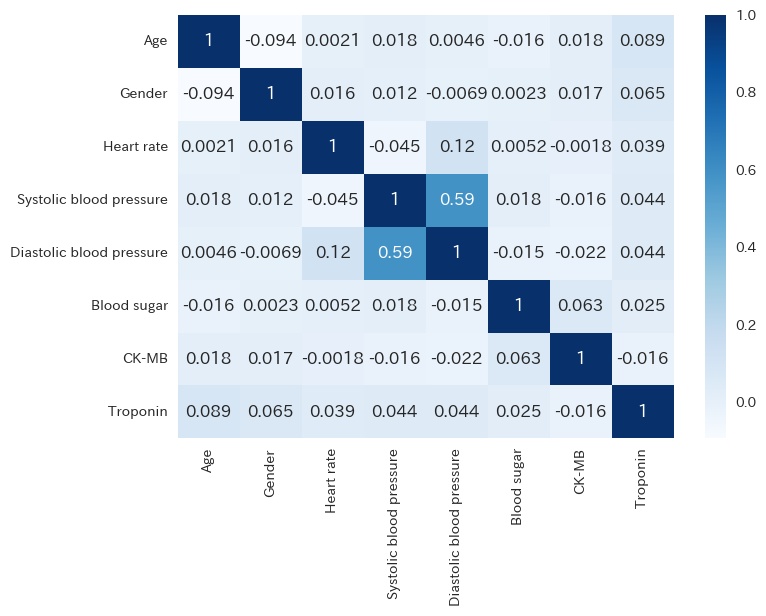

In [8]:
sns.heatmap(
    df.select_dtypes(include=['number']).corr(),
    cmap='Blues',
    annot=True
)
plt.show()

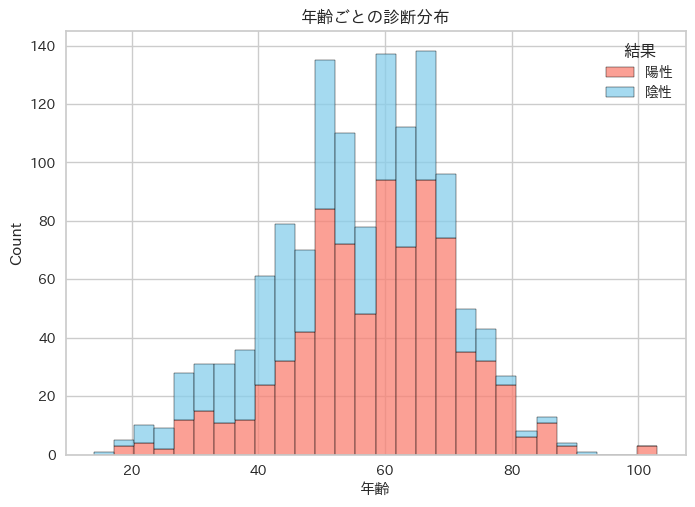

In [9]:
sns.histplot(
    df,
    x='Age',
    hue='Result',
    hue_order=['negative', 'positive'],
    multiple='stack',
    palette={'negative': "skyblue", 'positive': "salmon"}
)
plt.legend(
    title='結果',
    labels=['陽性', '陰性']
)
plt.xlabel('年齢')
plt.title('年齢ごとの診断分布')
plt.show()

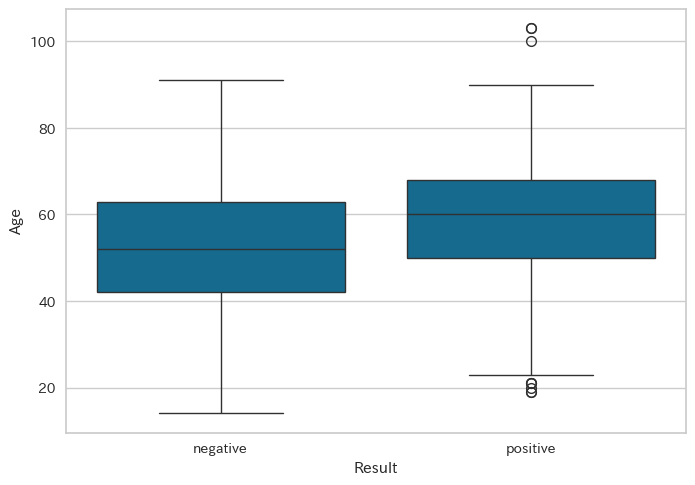

In [10]:
sns.boxplot(
    df,
    x='Result',
    y='Age'
)
plt.show()

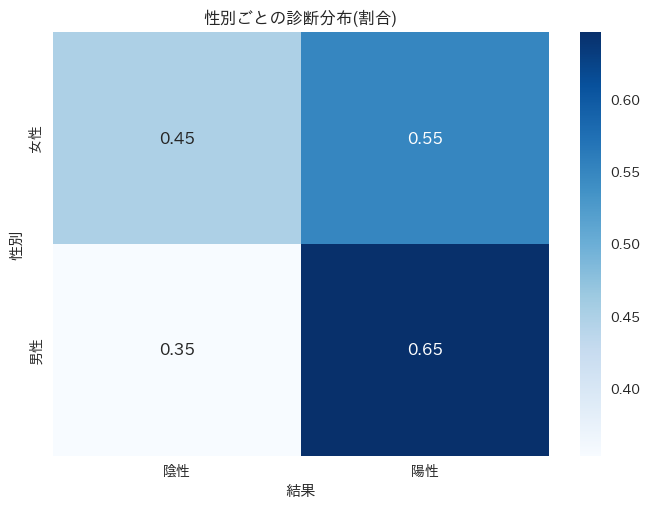

In [11]:
ct = pd.crosstab(
    df['Gender'],
    df['Result'],
    normalize='index',
    rownames=['性別'],
    colnames=['結果']
)
ct = ct.rename(
    index={0:'女性', 1:'男性'},
    columns={'negative':'陰性', 'positive':'陽性'}
)
sns.heatmap(
    ct,
    annot=True,
    cmap='Blues'
)
plt.title('性別ごとの診断分布(割合)')
plt.show()

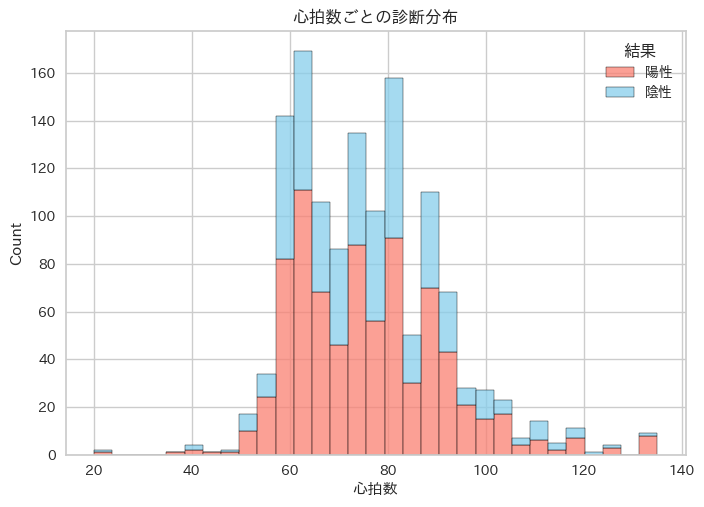

In [14]:
sns.histplot(
    df,
    x='Heart rate',
    hue='Result',
    hue_order=['negative', 'positive'],
    multiple='stack',
    palette={'negative': "skyblue", 'positive': "salmon"}
)
plt.legend(
    title='結果',
    labels=['陽性', '陰性']
)
plt.xlabel('心拍数')
plt.title('心拍数ごとの診断分布')
plt.show()

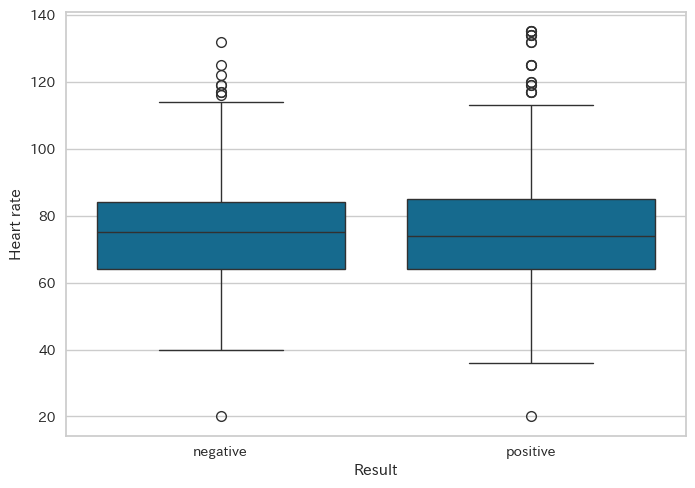

In [15]:
sns.boxplot(
    df,
    x='Result',
    y='Heart rate'
)
plt.show()

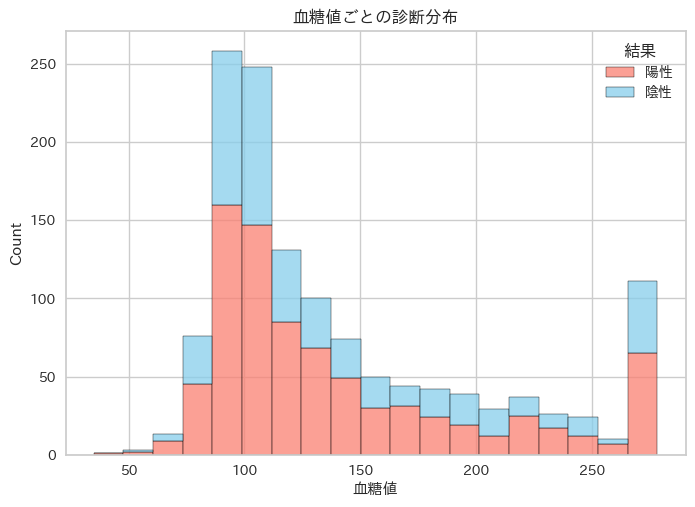

In [12]:
sns.histplot(
    df,
    x='Blood sugar',
    hue='Result',
    hue_order=['negative', 'positive'],
    multiple='stack',
    palette={'negative': "skyblue", 'positive': "salmon"}
)
plt.legend(
    title='結果',
    labels=['陽性', '陰性']
)
plt.xlabel('血糖値')
plt.title('血糖値ごとの診断分布')
plt.show()

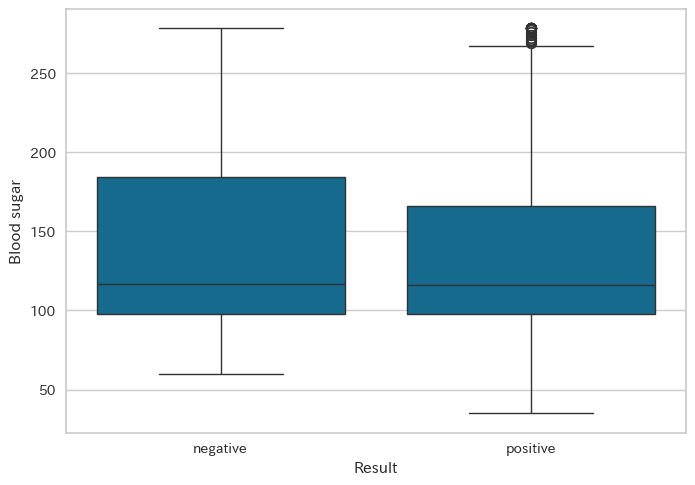

In [13]:
sns.boxplot(
    df,
    x='Result',
    y='Blood sugar'
)
plt.show()

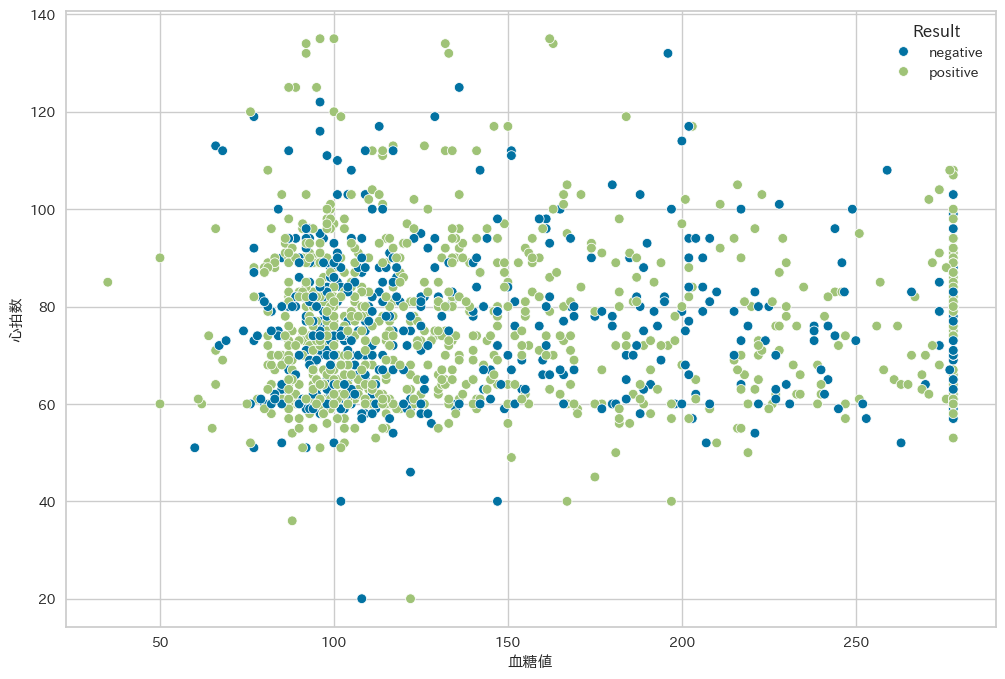

In [14]:
plt.figure(figsize=(12,8))
sns.scatterplot(
    df,
    x='Blood sugar',
    y='Heart rate',
    hue='Result',
    hue_order=['negative','positive']
)
plt.xlabel('血糖値')
plt.ylabel('心拍数')
plt.show()

- → 血糖値/心拍数と診断結果の相関はあまりないように見受けられる
- → 血糖値と心拍数もそれほど相関していない

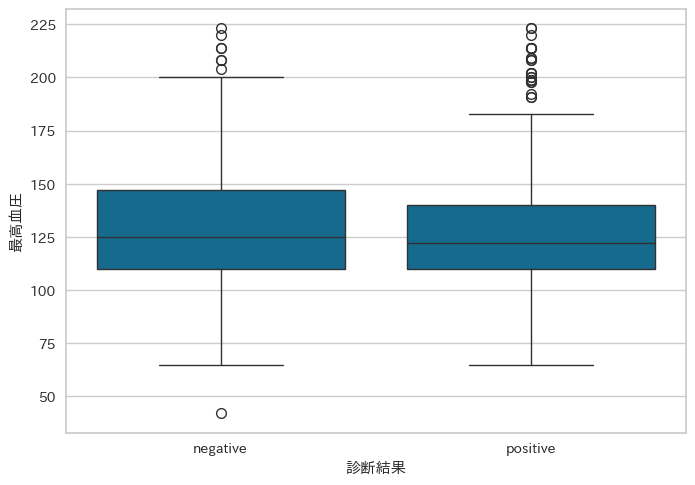

In [17]:
sns.boxplot(
    df,
    x='Result',
    y='Systolic blood pressure'
)
plt.xlabel('診断結果')
plt.ylabel('最高血圧')
plt.show()

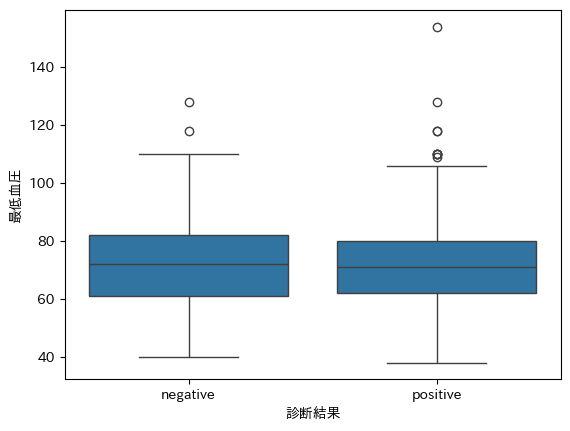

In [23]:
sns.boxplot(
    df,
    x='Result',
    y='Diastolic blood pressure'
)
plt.xlabel('診断結果')
plt.ylabel('最低血圧')
plt.show()

In [41]:
# 脈圧
df['Pulse pressure'] = df['Systolic blood pressure'] - df['Diastolic blood pressure']

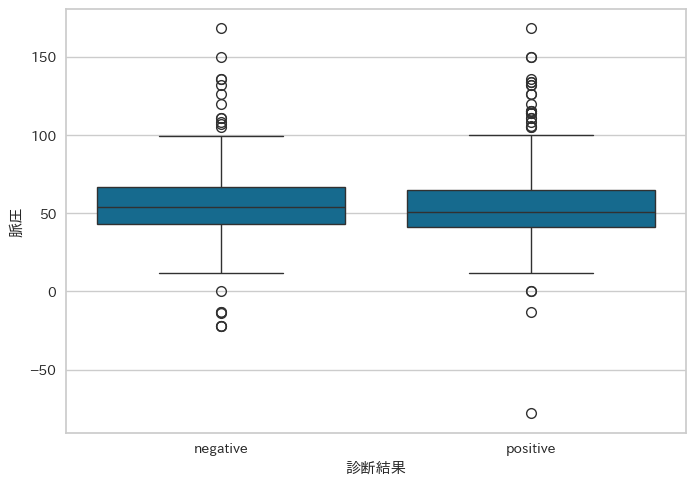

In [16]:
sns.boxplot(
    df,
    x='Result',
    y='Pulse pressure'
)
plt.xlabel('診断結果')
plt.ylabel('脈圧')
plt.show()

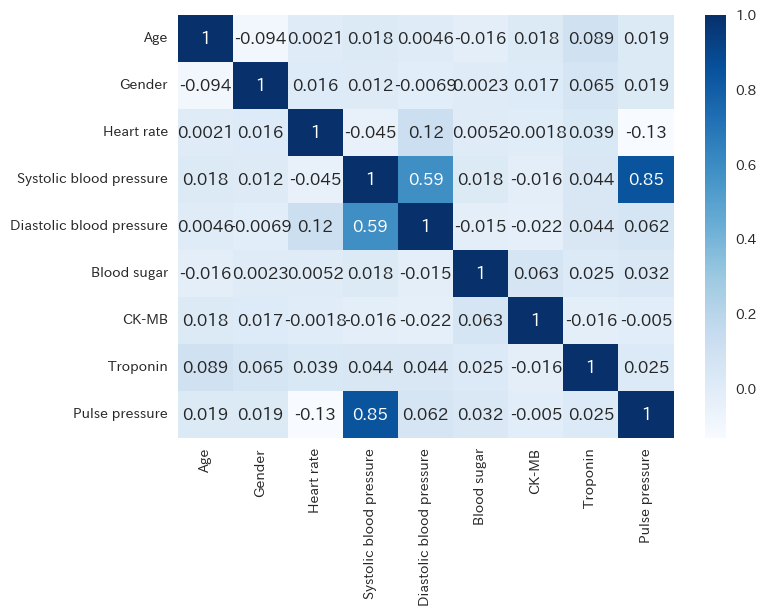

In [17]:
sns.heatmap(
    df.select_dtypes(include=['number']).corr(),
    cmap='Blues',
    annot=True
)
plt.show()

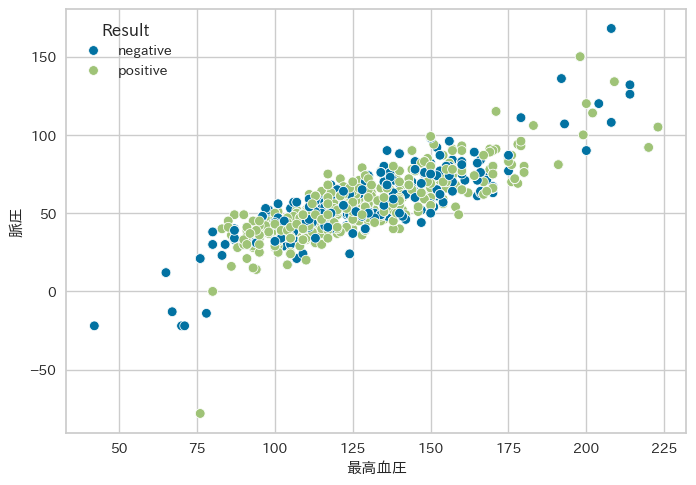

In [18]:
sns.scatterplot(
    df,
    x='Systolic blood pressure',
    y='Pulse pressure',
    hue='Result'
)
plt.xlabel('最高血圧')
plt.ylabel('脈圧')
plt.show()

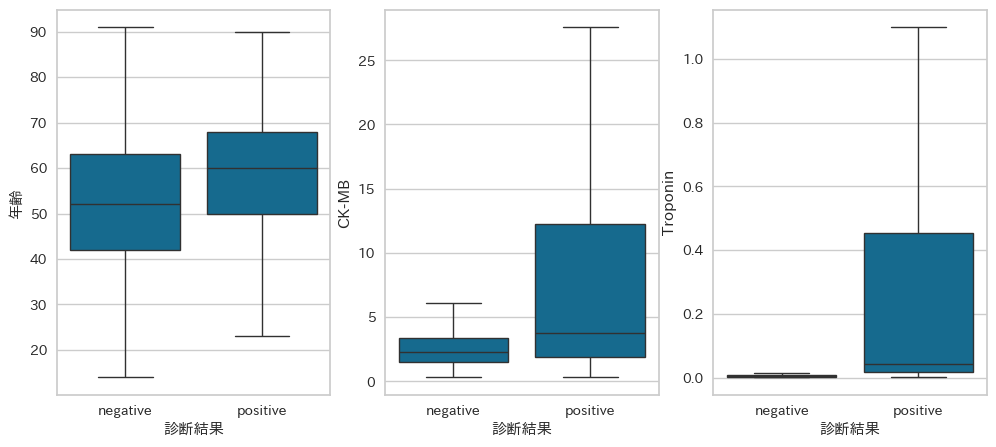

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(12,5))
sns.boxplot(
    df,
    x='Result',
    y='Age',
    showfliers=False,
    ax=ax[0]
)
ax[0].set_xlabel('診断結果')
ax[0].set_ylabel('年齢')
sns.boxplot(
    df,
    x='Result',
    y='CK-MB',
    showfliers=False,
    ax=ax[1]
)
ax[1].set_xlabel('診断結果')
ax[1].set_ylabel('CK-MB')
sns.boxplot(
    df,
    x='Result',
    y='Troponin',
    showfliers=False,
    ax=ax[2]
)
ax[2].set_xlabel('診断結果')
ax[2].set_ylabel('Troponin')
plt.show()

- → 診断結果とある程度相関がありそうなのは、年齢/CK-MB/Troponin くらい

### 予測モデル作成

In [42]:
df['Result'] = df['Result'].map({'negative':0, 'positive': 1})

In [44]:
df_train, df_test = train_test_split(df, test_size=0.2, stratify=df['Result'])

In [45]:
clf = setup(data=df_train, target='Result')

,Description,Value
0,Session id,1891
1,Target,Result
2,Target type,Binary
3,Original data shape,"(1052, 10)"
4,Transformed data shape,"(1052, 10)"
5,Transformed train set shape,"(736, 10)"
6,Transformed test set shape,"(316, 10)"
7,Numeric features,9
8,Preprocess,True
9,Imputation type,simple


In [47]:
best_model = compare_models()
tuned_model = tune_model(best_model)
final_model = finalize_model(tuned_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dt,Decision Tree Classifier,0.9878,0.9874,0.9890,0.9914,0.9900,0.9742,0.9748,0.0040
rf,Random Forest Classifier,0.9864,0.9967,0.9846,0.9935,0.9888,0.9715,0.9721,0.0310
gbc,Gradient Boosting Classifier,0.9864,0.9948,0.9846,0.9935,0.9888,0.9715,0.9721,0.0280
xgboost,Extreme Gradient Boosting,0.9851,0.9922,0.9824,0.9935,0.9877,0.9687,0.9693,0.0080
ada,Ada Boost Classifier,0.9837,0.9936,0.9846,0.9894,0.9867,0.9655,0.9665,0.0150
lightgbm,Light Gradient Boosting Machine,0.9837,0.9969,0.9801,0.9934,0.9866,0.9658,0.9665,0.1850
et,Extra Trees Classifier,0.9374,0.9829,0.9426,0.9565,0.9490,0.8680,0.8695,0.0330
qda,Quadratic Discriminant Analysis,0.8927,0.9909,0.8254,1.0000,0.9037,0.7854,0.8049,0.0050
nb,Naive Bayes,0.8873,0.9931,0.8164,1.0000,0.8979,0.7754,0.7967,0.0040
lr,Logistic Regression,0.7881,0.8897,0.7941,0.8507,0.8198,0.5626,0.5668,0.0080


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9865,0.9891,0.9783,1.0000,0.9890,0.9715,0.9719
1,0.9730,0.9783,0.9565,1.0000,0.9778,0.9433,0.9449
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,0.9730,0.9778,0.9556,1.0000,0.9773,0.9440,0.9455
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,0.9865,0.9828,1.0000,0.9783,0.9890,0.9715,0.9719
6,0.9863,0.9972,1.0000,0.9783,0.9890,0.9708,0.9712
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.9726,0.9778,0.9556,1.0000,0.9773,0.9428,0.9444


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [48]:
test_pred = predict_model(final_model, data=df_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.9848,0.9840,0.9877,0.9877,0.9877,0.9680,0.9680


In [49]:
test_pred

,Age,Gender,Heart rate,Systolic blood pressure,Diastolic blood pressure,Blood sugar,CK-MB,Troponin,Pulse pressure,Result,prediction_label,prediction_score
716,60,0,83,150,94,246.70,1.03,0.00,56,0,0,1.00
246,57,0,61,112,56,103.00,2.98,0.00,56,0,0,1.00
1266,66,1,84,160,79,141.00,2.57,0.01,81,0,0,1.00
222,55,1,122,147,95,96.00,3.86,0.00,52,0,0,1.00
852,57,1,51,130,70,92.00,4.25,0.01,60,0,0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...
248,50,0,63,129,67,94.00,3.23,0.00,62,0,0,1.00
755,55,1,63,104,87,98.00,3.65,0.01,17,0,0,1.00
396,50,1,88,134,86,100.00,5.39,2.63,48,1,1,1.00
496,50,1,61,117,78,276.00,4.39,2.34,39,1,1,1.00


In [72]:
auc = roc_auc_score(test_pred['Result'], test_pred['prediction_label'])
auc

0.9840232389251996

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.9730,0.9891,0.9565,1.0000,0.9778,0.9433,0.9449
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,0.9730,0.9778,0.9556,1.0000,0.9773,0.9440,0.9455
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,0.9865,0.9824,1.0000,0.9783,0.9890,0.9715,0.9719
6,0.9863,0.9821,1.0000,0.9783,0.9890,0.9708,0.9712
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,0.9863,0.9889,0.9778,1.0000,0.9888,0.9712,0.9716


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Decision Tree Classifier,0.9811,0.9887,0.9877,0.9816,0.9846,0.9600,0.9600


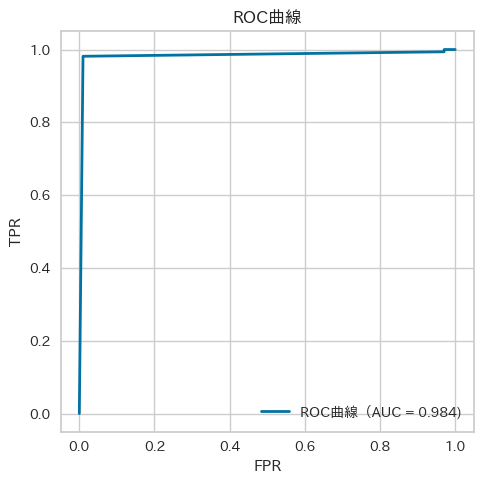

In [74]:
calibrated_model = calibrate_model(final_model, method='sigmoid')
calib_pred = predict_model(calibrated_model, data=df_test)
fpr, tpr, thresholds = roc_curve(calib_pred['Result'], calib_pred['prediction_score'])
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, lw=2, label=f'ROC曲線（AUC = {auc:.3f})')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC曲線')
plt.legend()
plt.tight_layout()
plt.show()

In [54]:
accuracy = accuracy_score(test_pred['Result'], test_pred['prediction_label'])
accuracy

0.9848484848484849

In [55]:
recall = recall_score(test_pred['Result'], test_pred['prediction_label'])
recall

0.9876543209876543

In [56]:
f1 = f1_score(test_pred['Result'], test_pred['prediction_label'])
f1

0.9876543209876543

- → データ量が少なく、過学習でスコアが異常に高くなっている印象がある